In [1608]:
from skimage import io
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix , plot_roc_curve , plot_confusion_matrix
from sklearn.metrics import accuracy_score , precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from statistics import mode
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from skimage import filters
import time


# Image Processing

## Load Data

In [1609]:
def load_images(data_pathes):
    #store train and test datasets in one array
    all_data = []
    for i in range(len(data_pathes)):
        df = pd.DataFrame()
        dirs = os.listdir(data_pathes[i])
        # looping over all selected folders using dirs array
        for folder_name in dirs:
            #store each image in its specified folder
            for file in os.listdir(data_pathes[i]+'/'+folder_name):
                image = io.imread(data_pathes[i]+'/'+folder_name+'/'+file)
                # resize images from 576 to 32 for width and height
                image = cv2.resize(image, (32, 32))
                # flatten the images to easily deal with it
                image = np.reshape(image,-1)
                # store image and its class in a dataframe
                dictt = {'image':image,'class':folder_name}
                df = df.append(dictt,ignore_index=True)
        all_data.append(df)
    return all_data[0],all_data[1]

In [1610]:
train_dir = 'textures/training'
test_dir = 'textures/testing'
data_pathes = [train_dir,test_dir]

train,test = load_images(data_pathes)

## Split train data to train and validate

In [1611]:
X_train , X_validate , y_train, y_validate = train_test_split(train['image'],train['class'] , test_size=0.33, random_state=20 , stratify=train['class'])

the validate dataset was generated from training dataset to be used in Image Matching function later to validate it

In [1612]:
train = pd.DataFrame({'image':X_train,'class':y_train})
validate = pd.DataFrame({'image':X_validate,'class':y_validate})

In [1613]:
train = train.sort_values('class').reset_index(drop=True)
validate = validate.sort_values('class').reset_index(drop=True)

# Image Matching

## Generate pairs of training , validation and testing data

In [1614]:
def generate_images(data):
    df =pd.DataFrame()
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            if(data['class'][i] == data['class'][j]):
                df = df.append({'img1':data['image'][i],'class1':data['class'][i] ,'img2':data['image'][j],'class2':data['class'][j],'match':1},ignore_index=True)
            else:
                df = df.append({'img1':data['image'][i],'class1':data['class'][i] ,'img2':data['image'][j],'class2':data['class'][j],'match':0},ignore_index=True)

    return df

generate_images function has data as input and it generate simmilar and different pairs from it and returns dataframe has 5 columns 
1. image 1 (numpy array)
2. class of image 1 (category)
3. image 2 (numpy array)
4. class of image 2 (category)
5. match (1 == simmilar , 0 == different)

In [1615]:
train_dataset = generate_images(train)
validate_dataset = generate_images(validate)
test_dataset = generate_images(test)

## Image Matching

In [1616]:
def cross_correlation(imageA,imageB):
    return np.sum(np.multiply(imageA,imageB))

In [1617]:
def convolution(imageA,imageB):
    # reverse image B
    reversedB = list(reversed(imageB))
    # multiply image A by reversed imageB and sum the resulted array
    return np.sum(np.multiply(imageA,reversedB))

In [1618]:
def sum_square_difference(imageA,imageB):
    return np.sum(np.square(np.subtract(imageA,imageB)))

image matching function has 4 inputs:
1. image1(numpy array)
2. image2(numpy array) 
3. method(cross correlation == cc| convolution == conv || sum of square difference == ssd) 
4. normalize (True|False)




In [1619]:
def imageMatching(imageA,imageB,method='cc',normalize=False):
    
    if method == 'cc':
        if normalize is False:
            threshold = cross_correlation(imageA,imageB)
            if threshold > 128901.5:
                return 1
            else:
                return 0
        else:
            imageA = imageA/255.0
            imageB = imageB/255.0
            threshold = cross_correlation(imageA,imageB)
            if threshold > 255:
                return 1
            else:
                return 0


    if method == 'conv':
        if normalize is False:
            threshold = convolution(imageA,imageB)
            if threshold < 127465.0:
                return 1
            else:
                return 0
        else:
            imageA = imageA/255.0
            imageB = imageB/255.0
            threshold = convolution(imageA,imageB)
            if threshold < 254.99870818915804:
                return 1
            else:
                return 0
                

    if method == 'ssd':
        if normalize is False:
            threshold = sum_square_difference(imageA,imageB)
            if threshold > 107557.5:
                return 1
            else:
                return 0
        else:
            imageA = imageA/255.0
            imageB = imageB/255.0
            threshold = sum_square_difference(imageA,imageB)
            if threshold > 47.45966935793925:
                return 1
            else:
                return 0


My approach in finding the threshold was to get the most frequent score in both simmilar and different from histogram by representing both of them, then get the average between them and set it as the threshold

Sometimes I found the threshold by guessing from the histogram as well

## Find best threshold for cross correlation

### Without Normalization

In [1620]:
different_images_results = []
simmilar_images_results = []
for i in range(len(train_dataset['img1'])):
    if(train_dataset['match'][i] == 0):
        different_images_results.append(
            cross_correlation(train_dataset['img1'][i],train_dataset['img2'][i])
        )   
    else:
        simmilar_images_results.append(
            cross_correlation(train_dataset['img1'][i],train_dataset['img2'][i])
        )

Most frequent score in simmilar images  : 128653
Most frequent score in different images : 129150
Average frequent score in all images : 128901.5


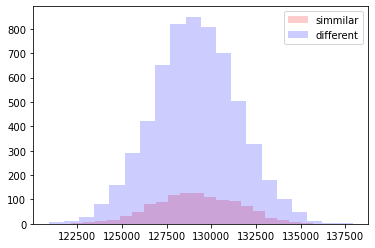

In [1621]:
y, x, _ = plt.hist(simmilar_images_results, bins=20,fc=(1, 0, 0, 0.2),label='simmilar')
y, x, _ = plt.hist(different_images_results, bins=20,fc=(0, 0, 1, 0.2),label='different')
plt.legend()
print("Most frequent score in simmilar images  : "+str(mode(simmilar_images_results)))
print("Most frequent score in different images : "+str(mode(different_images_results)))
print("Average frequent score in all images : "+str(np.average([mode(simmilar_images_results),mode(different_images_results)])))

In [1622]:
predictions = []
for i in range(len(validate_dataset['img1'])):
    predictions.append(imageMatching(validate_dataset['img1'][i],validate_dataset['img2'][i],'cc',False))
print(classification_report(validate_dataset['match'],predictions))
print(confusion_matrix(validate_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.83      0.48      0.61      1500
         1.0       0.14      0.47      0.22       270

    accuracy                           0.48      1770
   macro avg       0.49      0.48      0.41      1770
weighted avg       0.73      0.48      0.55      1770

[[726 774]
 [144 126]]


### With Normalization

In [1623]:
different_images_results = []
simmilar_images_results = []
for i in range(len(train_dataset['img1'])):
    if(train_dataset['match'][i] == 0):
        different_images_results.append(
            cross_correlation(train_dataset['img1'][i]/255.0,train_dataset['img2'][i]/255.0)
        )   
    else:
        simmilar_images_results.append(
            cross_correlation(train_dataset['img1'][i]/255.0,train_dataset['img2'][i]/255.0)
        )


Most frequent score in simmilar images : 254.99498654363708
Most frequent score in different images : 252.7996155324875


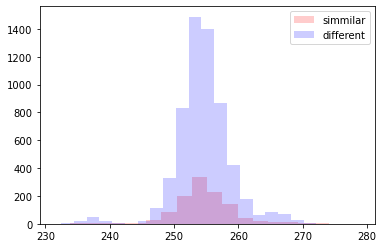

In [1624]:
y, x, _ = plt.hist(simmilar_images_results, bins=20,fc=(1, 0, 0, 0.2),label='simmilar')
y, x, _ = plt.hist(different_images_results, bins=20,fc=(0, 0, 1, 0.2),label='different')
plt.legend()
print("Most frequent score in simmilar images : "+str(mode(simmilar_images_results)))
print("Most frequent score in different images : "+str(mode(different_images_results)))

In [1625]:
predictions = []
for i in range(len(validate_dataset['img1'])):
    predictions.append(imageMatching(validate_dataset['img1'][i],validate_dataset['img2'][i],'cc',True))
    
print(classification_report(validate_dataset['match'],predictions))
print(confusion_matrix(validate_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.57      0.68      1500
         1.0       0.14      0.39      0.20       270

    accuracy                           0.54      1770
   macro avg       0.49      0.48      0.44      1770
weighted avg       0.73      0.54      0.60      1770

[[852 648]
 [166 104]]


## Find best threshold for convolution

### without normalization

In [1626]:
different_images_results = []
simmilar_images_results = []
for i in range(len(train_dataset['img1'])):
    if(train_dataset['match'][i] == 0):
        different_images_results.append(
            convolution(train_dataset['img1'][i],train_dataset['img2'][i])
        )   
    else:
        simmilar_images_results.append(
            convolution(train_dataset['img1'][i],train_dataset['img2'][i])
        )

Most frequent score in simmilar images  : 126117
Most frequent score in different images : 128813
Average frequent score in all images : 127465.0


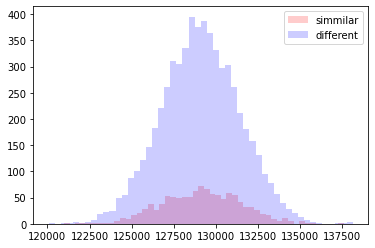

In [1627]:
y, x, _ = plt.hist(simmilar_images_results, bins=50,fc=(1, 0, 0, 0.2),label='simmilar')
y, x, _ = plt.hist(different_images_results, bins=50,fc=(0, 0, 1, 0.2),label='different')
plt.legend()
print("Most frequent score in simmilar images  : "+str(mode(simmilar_images_results)))
print("Most frequent score in different images : "+str(mode(different_images_results)))
print("Average frequent score in all images : "+str(np.average([mode(simmilar_images_results),mode(different_images_results)])))


In [1628]:
predictions = []
for i in range(len(validate_dataset['img1'])):
    predictions.append(imageMatching(validate_dataset['img1'][i],validate_dataset['img2'][i],'conv',False))
print(classification_report(validate_dataset['match'],predictions))
print(confusion_matrix(validate_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79      1500
         1.0       0.14      0.23      0.18       270

    accuracy                           0.67      1770
   macro avg       0.49      0.49      0.49      1770
weighted avg       0.74      0.67      0.70      1770

[[1122  378]
 [ 207   63]]


### with normaliztion

In [1629]:
different_images_results = []
simmilar_images_results = []
for i in range(len(train_dataset['img1'])):
    if(train_dataset['match'][i] == 0):
        different_images_results.append(
            convolution(train_dataset['img1'][i]/255.0,train_dataset['img2'][i]/255.0)
        )   
    else:
        simmilar_images_results.append(
            convolution(train_dataset['img1'][i]/255.0,train_dataset['img2'][i]/255.0)
        )

Most frequent score in simmilar images  : 257.6966858900423
Most frequent score in different images : 254.30073048827376
Average frequent score in all images : 255.99870818915804


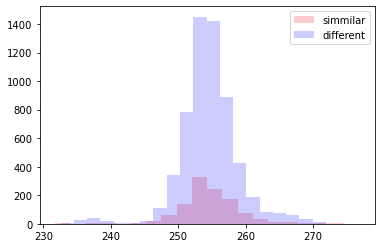

In [1630]:
y, x, _ = plt.hist(simmilar_images_results, bins=20,fc=(1, 0, 0, 0.2),label='simmilar')
y, x, _ = plt.hist(different_images_results, bins=20,fc=(0, 0, 1, 0.2),label='different')
plt.legend()
print("Most frequent score in simmilar images  : "+str(mode(simmilar_images_results)))
print("Most frequent score in different images : "+str(mode(different_images_results)))
print("Average frequent score in all images : "+str(np.average([mode(simmilar_images_results),mode(different_images_results)])))


In [1631]:
predictions = []
for i in range(len(validate_dataset['img1'])):
    predictions.append(imageMatching(validate_dataset['img1'][i],validate_dataset['img2'][i],'conv',True))
print(classification_report(validate_dataset['match'],predictions))
print(confusion_matrix(validate_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.42      0.56      1500
         1.0       0.15      0.57      0.24       270

    accuracy                           0.44      1770
   macro avg       0.50      0.49      0.40      1770
weighted avg       0.74      0.44      0.51      1770

[[625 875]
 [117 153]]


## Find the best threshold for sum square difference

### without normalization

In [1632]:
different_images_results = []
simmilar_images_results = []
for i in range(len(train_dataset['img1'])):
    if(train_dataset['match'][i] == 0):
        different_images_results.append(
            sum_square_difference(train_dataset['img1'][i],train_dataset['img2'][i])
        )   
    else:
        simmilar_images_results.append(
            sum_square_difference(train_dataset['img1'][i],train_dataset['img2'][i])
        )

Most frequent score in simmilar images  : 107058
Most frequent score in different images : 108057
Average frequent score in all images : 107557.5


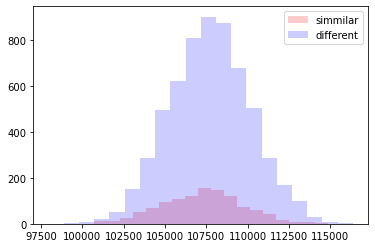

In [1633]:
y, x, _ = plt.hist(simmilar_images_results, bins=20,fc=(1, 0, 0, 0.2),label='simmilar')
y, x, _ = plt.hist(different_images_results, bins=20,fc=(0, 0, 1, 0.2),label='different')
plt.legend()
print("Most frequent score in simmilar images  : "+str(mode(simmilar_images_results)))
print("Most frequent score in different images : "+str(mode(different_images_results)))
print("Average frequent score in all images : "+str(np.average([mode(simmilar_images_results),mode(different_images_results)])))

In [1634]:
predictions = []
for i in range(len(validate_dataset['img1'])):
    predictions.append(imageMatching(validate_dataset['img1'][i],validate_dataset['img2'][i],'ssd',False))
print(classification_report(validate_dataset['match'],predictions))
print(confusion_matrix(validate_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.48      0.61      1500
         1.0       0.15      0.50      0.23       270

    accuracy                           0.48      1770
   macro avg       0.50      0.49      0.42      1770
weighted avg       0.74      0.48      0.55      1770

[[723 777]
 [135 135]]


### with normalization

In [1635]:
different_images_results = []
simmilar_images_results = []
for i in range(len(train_dataset['img1'])):
    if(train_dataset['match'][i] == 0):
        different_images_results.append(
            sum_square_difference(train_dataset['img1'][i]/255.0,train_dataset['img2'][i]/255.0)
        )   
    else:
        simmilar_images_results.append(
            sum_square_difference(train_dataset['img1'][i]/255.0,train_dataset['img2'][i]/255.0)
        )

Most frequent score in simmilar images  : 41.35692425990003
Most frequent score in different images : 43.56241445597847
Average frequent score in all images : 42.45966935793925


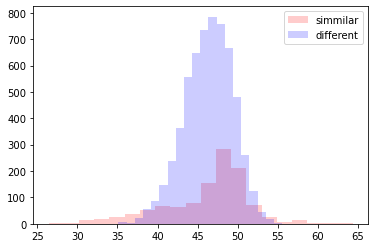

In [1636]:
y, x, _ = plt.hist(simmilar_images_results, bins=20,fc=(1, 0, 0, 0.2),label='simmilar')
y, x, _ = plt.hist(different_images_results, bins=20,fc=(0, 0, 1, 0.2),label='different')
plt.legend()
print("Most frequent score in simmilar images  : "+str(mode(simmilar_images_results)))
print("Most frequent score in different images : "+str(mode(different_images_results)))
print("Average frequent score in all images : "+str(np.average([mode(simmilar_images_results),mode(different_images_results)])))


In [1637]:
predictions = []
for i in range(len(validate_dataset['img1'])):
    predictions.append(imageMatching(validate_dataset['img1'][i],validate_dataset['img2'][i],'ssd',True))
print(classification_report(validate_dataset['match'],predictions))
print(confusion_matrix(validate_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.65      0.75      1500
         1.0       0.21      0.52      0.30       270

    accuracy                           0.63      1770
   macro avg       0.55      0.58      0.52      1770
weighted avg       0.78      0.63      0.68      1770

[[972 528]
 [130 140]]


## Discussion

It was difficult to have a real threshold that seperates the datasets because of two things:
1. Images are very simmilar to each other
2. Images are grayscaled so coloring differentiation is missed so if the images were identical in shape so colors could have differentiated by adding different values

Results:

1. It was expected that different images to be predicted more than simmilar ones different images has much more pairs than simmilar ones
2. Using normalization had a slight improvment in cross correlation and SSD so it increased both accuracy and f1-score in both of them 
3. convolution without normalization was the best combination cause it resulted in **0.67** accuracy score and **0.49**  f1-score which were the hightest scores in all methods combinations
4. having the average of the most frequent score in simmilar and different classes was a successful way to determine the threshold

# Perceptron

## Sub Sampling

In [1638]:
train_dataset = train_dataset.sample(frac=1)
class_1_train = train_dataset[train_dataset['match'] == 1]
class_0_train = train_dataset[train_dataset['match'] == 0]
train_dataset_balance = pd.concat([class_1_train,class_0_train[0:len(class_1_train)]])
train_dataset_balance= train_dataset_balance.reset_index()

In [1639]:
x_train = []
for i in range(len(train_dataset_balance)):
    x_train.append(np.append(train_dataset_balance['img1'][i] , train_dataset_balance['img2'][i]))
y_train = train_dataset_balance['match']

x_validate = []
for i in range(len(validate_dataset)):
    x_validate.append(np.append(validate_dataset['img1'][i],validate_dataset['img2'][i]))
y_validate = validate_dataset['match']

In [1640]:
model = MLPClassifier(max_iter=20,solver='adam',learning_rate_init=0.001,hidden_layer_sizes=(100,),alpha=0.00015,verbose='true',random_state=10)
model.fit(x_train, y_train)

Iteration 1, loss = 17.45836231
Iteration 2, loss = 16.49604081
Iteration 3, loss = 14.91405092
Iteration 4, loss = 10.59800811
Iteration 5, loss = 9.28960674
Iteration 6, loss = 7.93780548
Iteration 7, loss = 6.54018680
Iteration 8, loss = 5.93406854
Iteration 9, loss = 4.47539282
Iteration 10, loss = 10.52320109
Iteration 11, loss = 11.96233414
Iteration 12, loss = 10.30894493
Iteration 13, loss = 8.55292667
Iteration 14, loss = 4.74367285
Iteration 15, loss = 2.74152864
Iteration 16, loss = 2.98774220
Iteration 17, loss = 1.77753807
Iteration 18, loss = 2.47400669
Iteration 19, loss = 5.39779736
Iteration 20, loss = 2.81479014


C:\Users\elsha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.00015, max_iter=20, random_state=10, verbose='true')

In [1641]:
print(f'Number of layers {model.n_layers_}')
for lyr in range(model.n_layers_-1):
   print('Layer {0}: Weights {1} Bias {2}'.format(lyr,model.coefs_[lyr].shape, model.intercepts_[lyr].shape))

y_pred = model.predict(x_train)
y_pred_test = model.predict(x_validate)
print('Classifier accuracy on the training set is {0} '.format(accuracy_score(y_train, y_pred)))
print('Classifier accuracy on the validate set is {0} '.format(accuracy_score(y_validate, y_pred_test)))

Number of layers 3
Layer 0: Weights (2048, 100) Bias (100,)
Layer 1: Weights (100, 1) Bias (1,)
Classifier accuracy on the training set is 0.5324561403508772 
Classifier accuracy on the validate set is 0.7598870056497176 


In [1642]:
print(classification_report(y_validate,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      1500
         1.0       0.17      0.14      0.16       270

    accuracy                           0.76      1770
   macro avg       0.51      0.51      0.51      1770
weighted avg       0.75      0.76      0.75      1770



# Classification Comparison

## image matching score:

we will use convolution without normalizatoin cause it gave us the best accuracy to compare it with MLP

In [1643]:
image_matching_time_before = time.time()
predictions = []
for i in range(len(test_dataset)):
    predictions.append(imageMatching(test_dataset['img1'][i],test_dataset['img2'][i],method='conv',normalize=False))
image_matching_time_after = time.time()
print(classification_report(test_dataset['match'],predictions))
print(confusion_matrix(test_dataset['match'],predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.75      0.79      1500
         1.0       0.16      0.27      0.20       270

    accuracy                           0.67      1770
   macro avg       0.51      0.51      0.50      1770
weighted avg       0.75      0.67      0.70      1770

[[1119  381]
 [ 197   73]]


In [1644]:
overall_time_imageMatcing = image_matching_time_after - image_matching_time_before
print("Image matching consumed time = "+str(overall_time_imageMatcing)+ " s") 

Image matching consumed time = 0.7180790901184082 s


## MultiLayer Perceptron Score:

In [1645]:
x_test = []
for i in range(len(test_dataset)):
    x_test.append(np.append(test_dataset['img1'][i],test_dataset['img2'][i]))
y_test = test_dataset['match']

In [1646]:
mlp_time_before = time.time()
y_pred_test = model.predict(x_test)
mlp_time_after = time.time()
print(classification_report(y_test,y_pred_test))
print(confusion_matrix(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      1500
         1.0       0.13      0.14      0.13       270

    accuracy                           0.73      1770
   macro avg       0.49      0.48      0.49      1770
weighted avg       0.73      0.73      0.73      1770

[[1249  251]
 [ 233   37]]


In [1647]:
overall_time_mlp = mlp_time_after - mlp_time_before
print("MLP consumed time = "+str(overall_time_mlp)+ " s") 

MLP consumed time = 0.07878899574279785 s


## Disscussion

1. Classification Performance:
    Image Matching was better in accuracy had accuracy with *67* which is better than MLP which had *50%* Accuracy
    MLP suffered from underfitting problems which can be solved with adding regularization
2. Robustness and generalization:
    Image Matching was better in overall generalization which had *0.50*, MLP was sligtly better in classifying the minor class (simmilar) with average *25%* f1-score for that class but Image Matching was better in classifying the major class(different) with average f1-score *80%* for that class
1. Speed of prediction: 
    MultiLayer Perceptron was very fast in comparison with imageMaching , it was faster by *0.46* seconds
2. Trainig effort:
    Multilayer perceptron took much higher training time and effort than ImageMatching from tuninig and choosing the best parameters, but Image Classifier was simple and fast classifier when it come to choose the threshold.

# Feature Engineering

## Apply Feature Enginnering on train , validate and test datasets

In [1648]:
def tuned_dataset(data):
    features_data = []
    for i in range(len(data)):
        # apply gaussian flters on both images:
        img1 = np.reshape(data['img1'][i],(32,32))
        img2 = np.reshape(data['img2'][i],(32,32))
        tuned_img1 = cv2.GaussianBlur(img1,(9,9),0)
        tuned_img2 = cv2.GaussianBlur(img2,(9,9),0)
        # apply canny edge detection on both images:
        tuned_img1 = cv2.Canny(img1, 100, 200)
        tuned_img2 = cv2.Canny(img2, 100, 200)

        #reshape both images to 4 X 4 
        tuned_img1 = cv2.resize(tuned_img1,(4,4))
        tuned_img2 = cv2.resize(tuned_img2,(4,4))
        
        tuned_img1 = np.reshape(tuned_img1,-1)
        tuned_img2 = np.reshape(tuned_img2,-1)

        features = np.append(tuned_img1,tuned_img2)
        features_data.append(features)
    return features_data

In [1649]:
tuned_train = tuned_dataset(train_dataset_balance)
tuned_validate = tuned_dataset(validate_dataset)
tuned_test = tuned_dataset(test_dataset)

In [1650]:
model = MLPClassifier(max_iter=100,early_stopping=True,solver='adam',learning_rate_init=0.001,hidden_layer_sizes=(100),verbose='true',alpha=0.0004)
model.fit(tuned_train, train_dataset_balance['match'])

Iteration 1, loss = 10.01855643
Validation score: 0.491228
Iteration 2, loss = 7.01194062
Validation score: 0.473684
Iteration 3, loss = 4.77103176
Validation score: 0.486842
Iteration 4, loss = 3.63058282
Validation score: 0.530702
Iteration 5, loss = 2.99330047
Validation score: 0.539474
Iteration 6, loss = 2.63695126
Validation score: 0.535088
Iteration 7, loss = 2.37052868
Validation score: 0.552632
Iteration 8, loss = 2.11524612
Validation score: 0.574561
Iteration 9, loss = 1.94633261
Validation score: 0.535088
Iteration 10, loss = 1.85410222
Validation score: 0.614035
Iteration 11, loss = 1.65000843
Validation score: 0.561404
Iteration 12, loss = 1.69287273
Validation score: 0.614035
Iteration 13, loss = 1.62859651
Validation score: 0.557018
Iteration 14, loss = 1.38374929
Validation score: 0.570175
Iteration 15, loss = 1.34388993
Validation score: 0.574561
Iteration 16, loss = 1.33338358
Validation score: 0.592105
Iteration 17, loss = 1.22407089
Validation score: 0.543860
Itera

MLPClassifier(alpha=0.0004, early_stopping=True, hidden_layer_sizes=100,
              max_iter=100, verbose='true')

In [1651]:
print(f'Number of layers {model.n_layers_}')
for lyr in range(model.n_layers_-1):
   print('Layer {0}: Weights {1} Bias {2}'.format(lyr,model.coefs_[lyr].shape, model.intercepts_[lyr].shape))

y_pred = model.predict(tuned_train)
y_pred_test = model.predict(tuned_validate)
print('Classifier accuracy on the training set is {0} '.format(accuracy_score(train_dataset_balance['match'], y_pred)))
print('Classifier accuracy on the validate set is {0} '.format(accuracy_score(validate_dataset['match'], y_pred_test)))
print(classification_report(validate_dataset['match'],y_pred_test))

Number of layers 3
Layer 0: Weights (32, 100) Bias (100,)
Layer 1: Weights (100, 1) Bias (1,)
Classifier accuracy on the training set is 0.6065789473684211 
Classifier accuracy on the validate set is 0.5644067796610169 
              precision    recall  f1-score   support

         0.0       0.84      0.60      0.70      1500
         1.0       0.15      0.39      0.21       270

    accuracy                           0.56      1770
   macro avg       0.50      0.49      0.46      1770
weighted avg       0.74      0.56      0.62      1770



In [1652]:
y_pred_test = model.predict(tuned_test)

print(classification_report(test_dataset['match'],y_pred_test))
print(confusion_matrix(test_dataset['match'],y_pred_test))

              precision    recall  f1-score   support

         0.0       0.86      0.59      0.70      1500
         1.0       0.17      0.46      0.25       270

    accuracy                           0.57      1770
   macro avg       0.51      0.53      0.48      1770
weighted avg       0.75      0.57      0.63      1770

[[890 610]
 [145 125]]


# Discussion on feature Engineering

### Before applying feature engineering the accuracy of the model was performing badly on test data but after applying feature engineering using gaussian filter which is used to blur the image followed by canny edge detection to focus on edges it highly increased the accuracy from *50%* to *63%* and f1-score increased from *44%* to *49%*

### The model still suffer from overfitting problems and biased towards the different class.